# =========================================================
#                    IMPORTS
# =========================================================

In [115]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# =========================================================
#                    GENERAL FUNCTIONS
# =========================================================

In [116]:
def read_sqlite_table(db_path: str, table_name: str) -> pd.DataFrame:
    """
    Reads a table from a SQLite database and returns it as a pandas DataFrame.

    Input:
    db_path : str
        Path to the SQLite database file.
    table_name : str
        Name of the table to read from the database.

    Output:
    pd.DataFrame
        A pandas DataFrame containing the data from the specified table.

    """

    # Connect to the SQLite database
    connection = sqlite3.connect(db_path)

    # Read the table into a pandas DataFrame using SQL query
    query = f"SELECT * FROM {table_name};"
    df = pd.read_sql_query(query, connection)

    # Convert the date column to pandas 'date' format
    df['date'] = pd.to_datetime(df['date'], format='%m/%d/%y')

    # Correct the years that should be from the 20th century
    df.loc[df['date'].dt.year > 2022, 'date'] = (
        df['date'] - pd.DateOffset(years=100)
    )
    
    # Close the connection
    connection.close()
    return df
            


In [117]:
def make_scores_df(matches_df: pd.DataFrame) -> pd.DataFrame:
    """
    Reads a matches DataFrame and returns a new DataFrame showing the scores
    annotated (anotated) and received per team.

    Input:
    matches_df : pd.DataFrame
        A DataFrame with match results.

    Output:
    pd.DataFrame
        A pandas DataFrame with columns:
        ['team', 'division', 'anotated_scores', 'received_scores']
    """

    # Remove matches without score
    matches_filtered = matches_df[matches_df['score'].notna()].copy()

    # Split score into goals
    matches_filtered[['home_goals', 'away_goals']] = matches_filtered['score'].str.split(':', expand=True).astype(int)

    # Create DataFrame for home and away teams
    home_df = matches_filtered[['division', 'home_team', 'home_goals', 'away_goals']].copy()
    home_df.columns = ['division', 'team', 'anotated_scores', 'received_scores']

    away_df = matches_filtered[['division', 'away_team', 'away_goals', 'home_goals']].copy()
    away_df.columns = ['division', 'team', 'anotated_scores', 'received_scores']

    # Combine both
    scores_df = pd.concat([home_df, away_df], ignore_index=True)

    # Aggregate by team and division
    scores_df = scores_df.groupby(['team', 'division'], as_index=False).sum()

    return scores_df

In [118]:
def make_final_standings_df(matches_df: pd.DataFrame, season: str, division: int) -> pd.DataFrame:
    """
    Reads a matches DataFrame and returns a new DataFrame showing the scores
    annotated (anotated) and received per team.

    Input:
    matches_df : pd.DataFrame
        A DataFrame with match results.

    Output:
    pd.DataFrame
        A pandas DataFrame with columns:
        ['team', 'division', 'anotated_scores', 'received_scores']
    """

    # Filter out matches with no result
    filtered_df = matches_df[matches_df['score'].notna()].copy()

    # Filter selected season and division
    filtered_df = filtered_df[(filtered_df['season'] == season) & 
        (filtered_df['division'] == division)]

    # Extract goals
    results_df = filtered_df.copy()
    results_df[['home_goals', 'away_goals']] = filtered_df['score'].str.split(':', expand=True).astype(int)
    # Add a column for the winning team of each match
    results_df['winner_team'] =results_df.apply(
        lambda x: x['home_team'] if x['home_goals'] > x['away_goals']
        else (x['away_team'] if x['away_goals'] > x['home_goals'] else 'DRAW'),
        axis=1
    )

    # Apply the make_scores_df general function to save the points per team
    df = make_scores_df(filtered_df)

    # Rename the columns to the format requested by the exercise
    df.rename(columns={'anotated_scores': 'GF'}, inplace=True)
    df.rename(columns={'received_scores': 'GA'}, inplace=True)

    # Add goal difference
    df['GD'] = df['GF'] - df['GA'] 

    # Add number of matches winned, losed and tie
    df["W"] = df["team"].apply(lambda x: sum(results_df["winner_team"] == x))
    df["L"] = df["team"].apply(lambda x: sum((results_df["home_team"] == x) & (results_df["winner_team"] != x)) + 
                                                    sum((results_df["away_team"] == x) & (results_df["winner_team"] != x)))
    df["T"] = df["team"].apply(
        lambda x: sum(
            (results_df["winner_team"] == "DRAW") &
            ((results_df["home_team"] == x) | (results_df["away_team"] == x))
        )
    )

    # Add points applying formula
    df["Pts"] = df["W"] * 3 + df["T"]

    # Sort table (Pts off, GD off, GF off)
    df = df.sort_values(by=["Pts", "GD", "GF"],
                                ascending=[False, False, False])

    return df


# =========================================================
#                    EXERCICES
# =========================================================

2. What are the top ten scoring teams of all time? What are the ten teams
that concede the most? Make two bar plot charts showing each of them.
Consider only matches played in 1st division.
What have been the biggest wins? Of course, when we say biggest we mean
those with the highest goal difference. Show the top ten of them in a table.

The 10 teams with the most goals scored are:
               team  anotated_scores
10        Barcelona             6267
48      Real Madrid             6249
5          Athletic             4802
65         Valencia             4615
8   Atlético Madrid             4184
59       Sevilla FC             3903
32         Espanyol             3720
51    Real Sociedad             3200
54    Real Zaragoza             2683
25    Celta de Vigo             2483


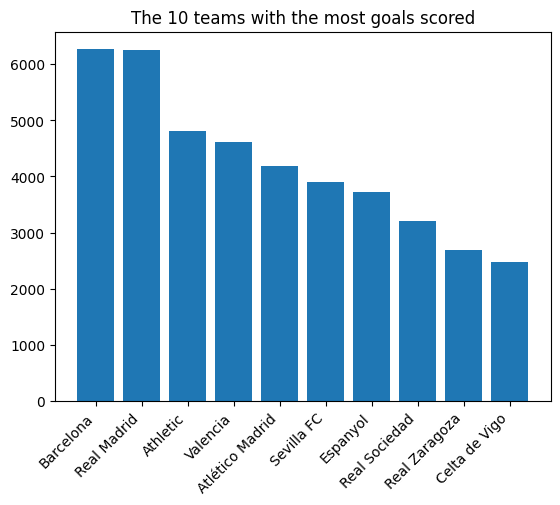

The 10 teams with the most goals recived are:
               team  received_scores
32         Espanyol             4034
5          Athletic             3875
65         Valencia             3649
59       Sevilla FC             3546
48      Real Madrid             3287
10        Barcelona             3259
51    Real Sociedad             3126
8   Atlético Madrid             2894
25    Celta de Vigo             2856
54    Real Zaragoza             2847


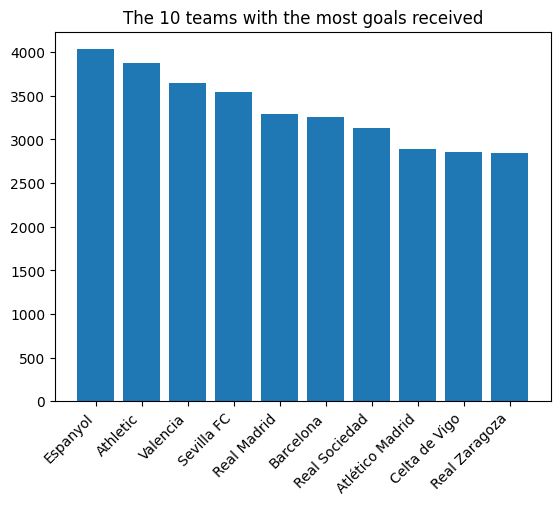

In [119]:
matches_df = read_sqlite_table('laliga.sqlite','matches')

# Filtter 1^st division
first_div_matches = matches_df[matches_df['division'] == 1]

# Use make_scores_df to build scores DataFrame
first_div_scores = make_scores_df(first_div_matches)

# 10 first teams with more scores anotatted
top_scored = first_div_scores.nlargest(10, 'anotated_scores')
print('The 10 teams with the most goals scored are:')
print(top_scored[['team', 'anotated_scores']])
plt.bar(top_scored['team'], top_scored['anotated_scores'])
plt.xticks(rotation=45, ha='right')
plt.title('The 10 teams with the most goals scored')
plt.show()

# 10 first teams with more scores recived
top_conceded = first_div_scores.nlargest(10, 'received_scores')
print('The 10 teams with the most goals recived are:')
print(top_conceded[['team', 'received_scores']])
plt.bar(top_conceded['team'], top_conceded['received_scores'])
plt.xticks(rotation=45, ha='right')
plt.title('The 10 teams with the most goals received')
plt.show()


In [120]:
# Filter out matches with no result
matches_results = matches_df[matches_df['score'].notna()].copy()

# Create columns for the home and away team goals
matches_results[['home_goals', 'away_goals']] = matches_results['score'].str.split(':', expand=True).astype(int)
# Calculate goal difference
matches_results['goal_diff'] = (matches_results['home_goals'] - matches_results['away_goals']).abs()

# 10 first matches with biggest goal difference
top_diff = matches_results.nlargest(10, 'goal_diff')
print("Top 10 biggest wins (by goal difference):")
print(top_diff[['home_team', 'away_team', 'score']])

Top 10 biggest wins (by goal difference):
           home_team        away_team score
25995  Real Sociedad  Real Valladolid  14:2
225         Athletic        Barcelona  12:1
27533     Real Gijón           Lérida  11:0
936       Sevilla FC        Barcelona  11:1
1071      Sevilla FC      Real Oviedo  10:0
1168        Athletic    Celta de Vigo  10:0
2787        Athletic           Lérida  10:0
26884   CE Sabadell   SD Erandio Club  11:1
28591  Real Sociedad     CE Sabadell   11:1
6           Athletic         Espanyol   9:0


4. Build a cross results table for season 2020-2021 (1st division). Figure 1 is an
example taken from Wikipedia. Try to make it the most similar to this one:
use team abbreviations as column names and paint the background of each
cell according to result (green in case local team wins and red in case visitor
team wins). Also, could you model the intensity of this background color
with the goal difference from the match?
Write a function that, given the season and division, plots the cross results
table. Function prototype should be like plot_cross_results_table(season, division) 
and return the plot object.

In [121]:
def plot_cross_results_table(matches_df: pd.DataFrame, season: str, division: int):
    """
    Plots a cross results table for the given season and division.
    The cell color represents the result: green for home wins, red for away wins,
    and intensity proportional to the goal difference.

    Input:
    matches_df : pd.DataFrame
        DataFrame with match results.
    season : str 
        Season to plot.
    division : int 
        Division to plot.

    Output:
        The matplotlib Axes object with the plot.
    """
    # Filter out matches with no result
    df = matches_df[matches_df['score'].notna()].copy()

    # Filter selected season and division
    df = df[(df['season'] == season) & 
        (df['division'] == division)]

    # Extract goals
    df[['home_goals', 'away_goals']] = df['score'].str.split(':', expand=True).astype(int)

    # Create abbreviations (first 3 letters per word uppercased)
    make_abbr = lambda name: ''.join([w[:3].upper() for w in name.split()])[:6]
    df['home_abbr'] = df['home_team'].apply(make_abbr)
    df['away_abbr'] = df['away_team'].apply(make_abbr)

    # Compute result and goal difference
    df['goal_diff'] = (df['home_goals'] - df['away_goals']).abs()
    df['result'] = df['home_goals'] - df['away_goals']

    # Remove duplicate entries for repeated matches (choose only the first one)
    df = df.drop_duplicates(subset=['season', 'division', 'home_team', 'away_team'], keep='first')

    # Pivot table with scores
    pivot = df.pivot(index='home_abbr', columns='away_abbr', values='score')

    # Matrix of colors: positive = green, negative = red, intensity by goal_diff
    color_matrix = df.pivot(index='home_abbr', columns='away_abbr', values='result')
    diff_matrix = df.pivot(index='home_abbr', columns='away_abbr', values='goal_diff')

    # Normalize color intensity
    norm_diff = diff_matrix / diff_matrix.max().max()
    cmap = plt.cm.RdYlGn

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_title(f"Cross Results Table — Season {season} (Division {division})")
    ax.set_xlabel('Home team')
    ax.set_ylabel('Away team')

    # Draw heatmap based on results
    sns.heatmap(color_matrix, annot=pivot, fmt='', cmap=cmap, center=0, linewidths=0.5,
                square=True, ax=ax)

    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    return ax

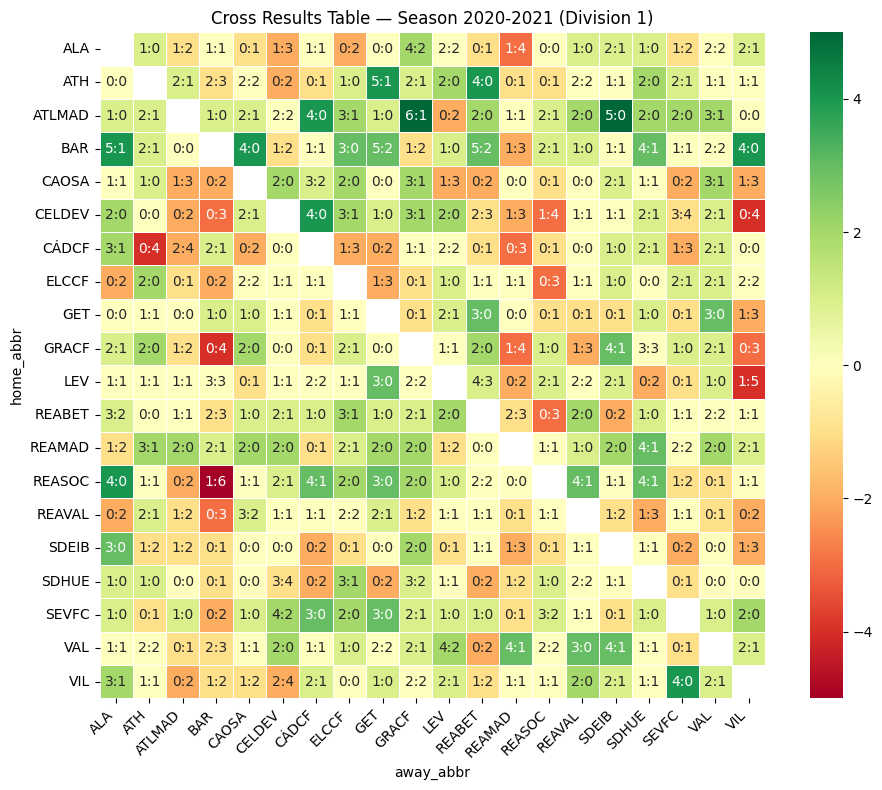

In [122]:
# Example of use for the first division in the 2020-2021 season
ax = plot_cross_results_table(matches_df, season='2020-2021', division=1)
plt.show()

6. Between 1979 and 1980, Real Sociedad managed to chain a total of 38 games
without losing. That was, by far, the longest undefeated streak in their history.
Which teams have had the longest undefeated streaks? Show the
longest undefeated streaks in a horizontal bar plot, indicating in each bar
the team name and the dates it held that streak, for instance, Real Sociedad
22/04/1979 - 04/05/1980.

In [123]:
teams = pd.unique(matches_df[['home_team', 'away_team']].values.ravel('K'))

# Add a column for the winning team of each match
matches_results['winner_team'] = matches_results.apply(
    lambda x: x['home_team'] if x['home_goals'] > x['away_goals']
    else (x['away_team'] if x['away_goals'] > x['home_goals'] else 'DRAW'),
    axis=1
)

team_max_streaks = {}

for team in teams:
    # Filter data for each team
    team_df = matches_results[(matches_results['home_team'] == team) | (matches_results['away_team'] == team)].copy()

    # Sort the data by ascending date
    team_df = team_df.sort_values('date')

    # Find the longest winning streak
    max_streak = []
    current_streak = []
    for _, match in team_df.iterrows():
        if match['winner_team'] == team or match['winner_team'] == 'DRAW':
            current_streak.append(match['date'])
        else:
            if len(current_streak)>len(max_streak):
                max_streak = current_streak
            current_streak = []
    
    # Add the max streak per team
    team_max_streaks[team] = max_streak

# Build streak DataFrame
streak_data = []
for team, streak in team_max_streaks.items():
    if len(streak) > 0:
        start_date = streak[0]
        end_date = streak[-1]
        streak_data.append({
            'team': team,
            'length': len(streak),
            'period': f"{start_date.strftime('%d/%m/%Y')} - {end_date.strftime('%d/%m/%Y')}"
        })

streak_df = pd.DataFrame(streak_data).sort_values('length', ascending=False)
print(streak_df)

                team  length                   period
5          Barcelona      43  15/04/2017 - 09/05/2018
24     Real Sociedad      38  29/04/1979 - 04/05/1980
2        Real Madrid      31  08/05/1988 - 09/04/1989
31   Real Valladolid      29  07/10/2006 - 29/04/2007
30   Atlético Madrid      26  08/02/2020 - 05/12/2020
..               ...     ...                      ...
94          Moscardó       3  18/10/1970 - 01/11/1970
78   SD Erandio Club       2  06/11/1949 - 13/11/1949
34   Atlético Tetuán       2  21/10/1951 - 28/10/1951
104   Atlético Ceuta       2  28/12/1980 - 03/01/1981
111   CFJ Mollerussa       1  11/09/1988 - 11/09/1988

[148 rows x 3 columns]


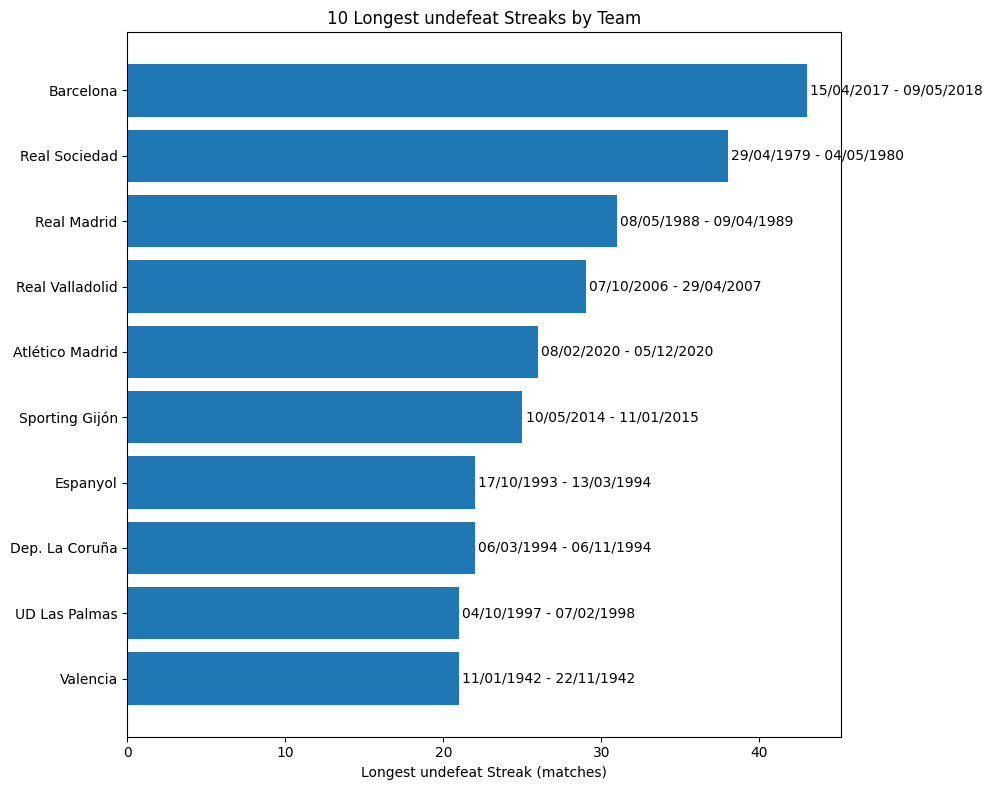

In [124]:
# Plot horizontal bar chart
plt.figure(figsize=(10, 8))
longest_streaks = streak_df.head(10)
bars = plt.barh(longest_streaks['team'], longest_streaks['length'])
plt.gca().invert_yaxis()
plt.xlabel('Longest undefeat Streak (matches)')
plt.title('10 Longest undefeat Streaks by Team')

# Add text with dates next to bars
for bar, period in zip(bars, streak_df['period']):
    plt.text(bar.get_width() + 0.2, bar.get_y() + bar.get_height()/2, period, va='center')

plt.tight_layout()
plt.show()

7. Create a table with the final standings of each season (and division), that
is, a table that contains all the teams ordered (in descending order) by the
number of points they got during that season, and some other aggregate
statistics. The table must contain the following columns: season, division,
ranking, team, GF (total goals scored), GA (total goals conceded), GD (goals
difference), W (total wins), L (total loses), T (total ties), Pts (points). Remember
that, in football, you earn 3 points per victory, and 1 point per tie (none
for loses). In case two teams have same number of points, order by GD (descending),
and then by GF (also descending). Order the table so that standings
of one season come before standings of previous one, and standings of
1st division come before standings of 2nd division.
Save the final table in Excel with the name SeasonStandings.xlsx in the
reports/ folder.

In [126]:
# Example of use for the first division in the 2020-2021 season
final_standings_df = make_final_standings_df(matches_df, season='2020-2021', division=1)
print(final_standings_df)

               team  division  GF  GA  GD   W   L   T  Pts
2   Atlético Madrid         1  67  25  42  26  12   8   86
12      Real Madrid         1  67  28  39  25  13   9   84
3         Barcelona         1  85  38  47  24  14   7   79
17       Sevilla FC         1  53  33  20  24  14   5   77
13    Real Sociedad         1  59  38  21  17  21  11   62
11       Real Betis         1  50  50   0  17  21  10   61
19       Villarreal         1  60  44  16  15  23  13   58
5     Celta de Vigo         1  55  57  -2  14  24  11   53
1          Athletic         1  46  42   4  11  27  13   46
9        Granada CF         1  47  65 -18  13  25   7   46
4        CA Osasuna         1  37  48 -11  11  27  11   44
6          Cádiz CF         1  36  58 -22  11  27  11   44
18         Valencia         1  50  53  -3  10  28  13   43
10          Levante         1  46  57 -11   9  29  14   41
8            Getafe         1  28  43 -15   9  29  11   38
0            Alavés         1  36  57 -21   9  29  11   

8. Villarreal is a team that has grown a lot in recent decades. Specially ever
since some billionaire guy bought it (Fernando Roig, from Mercadona).
Make a line plot showing the rank of Villarreal at the end of each season,
from the oldest ones (left) to the earliest ones (right). Consider rankings in
2nd division to be a continuation of the 1st one, that is, if there’s N teams in
1st division and Villarreal got r position in 2nd division, then it should be
placed in N + r. Draw in the same plot a line showing the cut between 1st
and 2nd division.
Write a function that, given n team names, plots the graph described above
of each one of them superposed. Function prototype should be like plot_-
ranking_evolution(team1, team2, ..., teamN) and return the plot object
(note that function should not take one array-type argument, but n arguments).
Use it to compare the evolution of all the teams that currently
play in 1st division.

In [ ]:
def plot_ranking_evolution(matches_df: pd.DataFrame, team_list: list):
    """
    Plots  the rank of position at the end of each season,
    from the oldest ones (left) to the earliest ones (right). 
    The rankings in 2nd division to be a continuation of the 1st.

    Input:
    matches_df : pd.DataFrame
        DataFrame with match results.
    team_list : list
        List of teams to plot.

    Output:
        The matplotlib Axes object with the plot.
    """
    # Ensures if team list is not empty
    if not team_list:
        print("You must provide a list of teams to plot. Example: ['Villarreal']")
        return

    seasons = sorted(matches_df['season'].unique())

    ranking_records = []
    for ssn in seasons:
        # Filter by each season
        season_df = matches_df[matches_df['season']==ssn]

        # Apply the make_scores_df general function to save the points per team
        season_points = make_scores_df(season_df)

        for div in sorted(season_points['division'].unique()):
            div_df = season_points[season_points['division'] == div]

            # Set ranking position
            div_df = div_df.sort_values('anotated_scores',ascending=False)
            ranking = pd.DataFrame()
            ranking['team'] = div_df['team'].values
            ranking['position'] = range(1, len(ranking) + 1)
            ranking['season'] = ssn
            ranking['division'] = div

            ranking_records.append(ranking)

    ranking_df = pd.concat(ranking_records, ignore_index=True)
    
    # Convert seasons 'YYYY-YYYY' into a whole number (final year) for graphing in order
    ranking_df['season_num'] = ranking_df['season'].apply(lambda s: int(s.split('-')[1]))

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_title("Ranking Evolution of Selected Teams")
    ax.set_xlabel("Season")
    ax.set_ylabel("Ranking position (lower = better)")

    # Determine separation line for divisions
    div1_size = ranking_df[ranking_df['division'] == 1]['team'].nunique()
    ax.axhline(y=div1_size + 0.5, color='gray', linestyle='--', alpha=0.5)

    # Plot each team’s ranking evolution
    for team in team_list:
        if team not in ranking_df['team'].values:
            print(f"The team '{team}' is not found in the dataset.")
            continue

        team_data = ranking_df[ranking_df['team'] == team].copy()
        team_data = team_data.sort_values(by='season_num')
        # Adjust position if in 2nd division (to continue under 1st)
        team_data['adj_position'] = team_data.apply(
            lambda x: x['position'] + div1_size if x['division'] == 2 else x['position'], axis=1
        )

        ax.plot(team_data['season'], team_data['adj_position'], marker='o', label=team)
    
    ax.legend()
    ax.set_ylim(1,)
    ax.set_xticks(range(0, len(seasons), 3))
    ax.set_xticklabels([seasons[i] for i in range(0, len(seasons), 3)], rotation=45)
    plt.tight_layout()
    return ax
    

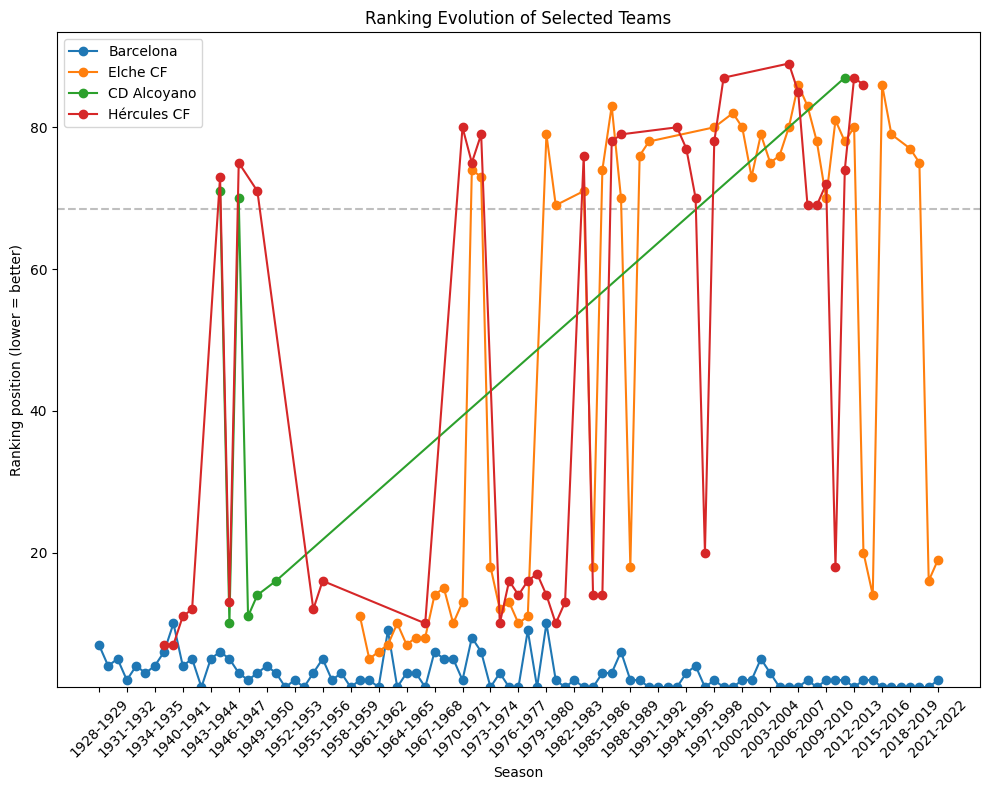

In [ ]:
# Example of use for random team sample
teams_to_plot = ['Barcelona', 'Elche CF', 'CD Alcoyano', 'Hércules CF']
ax = plot_ranking_evolution(matches_df, teams_to_plot)
plt.show()